In [32]:
import pandas as pd
import numpy as np
from keybert import KeyBERT
import joblib
import plotly
import pandas as pd

from collections import OrderedDict

import matplotlib
from umap import UMAP
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import pyLDAvis
from pyLDAvis import gensim_models

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [2]:
data = pd.read_csv('./Customer Complaints.csv')
data = data.iloc[: , 1:]
data = data[data['narrative'] != 'name']
data = data[data['narrative'].notna()]
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True)
print(data.shape)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(124618, 3)


In [3]:
df = data
df.head()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


index                 product  \
0      0  Transaction Processing   
1      1  Transaction Processing   
2      2          retail_banking   
3      3  Transaction Processing   
4      4  Transaction Processing   

                                           narrative  
0  purchase order day shipping amount receive pro...  
1  forwarded message date tue subject please inve...  
2  forwarded message cc sent friday pdt subject f...  
3  payment history missing credit report speciali...  
4  payment history missing credit report made mis...

In [4]:
print(df['product'].value_counts())
counts = df['product'].value_counts().values

Transaction Processing    71293
debt_collection           39852
retail_banking            13473
Name: product, dtype: int64


/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


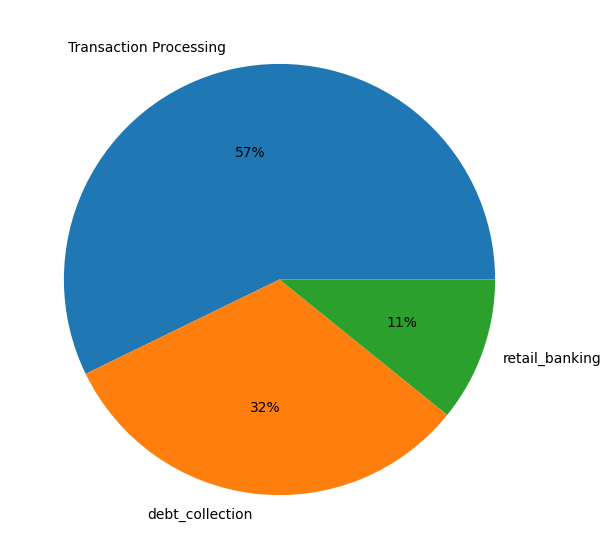

In [5]:
# Creating dataset
product = ['Transaction Processing', 'debt_collection', 'retail_banking']
  
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(counts, labels = product, autopct='%1.0f%%')
  
# show plot
plt.show()

Looking at the pie-chart above, we can see that majority of the complaints have been related to Transaction Processing. Fewest complaints were recieved for retail_banking.

In [6]:
plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams['figure.dpi'] = 400
plotly.offline.init_notebook_mode()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Retail Banking

In [7]:
df_RB = df[df['product'] == 'retail_banking']
df_RB.reset_index(inplace=True)
df_RB = df_RB[:10000]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [8]:
comment_words = ""
for i in df_RB.narrative: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
      
    comment_words += " ".join(separate)+" "

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



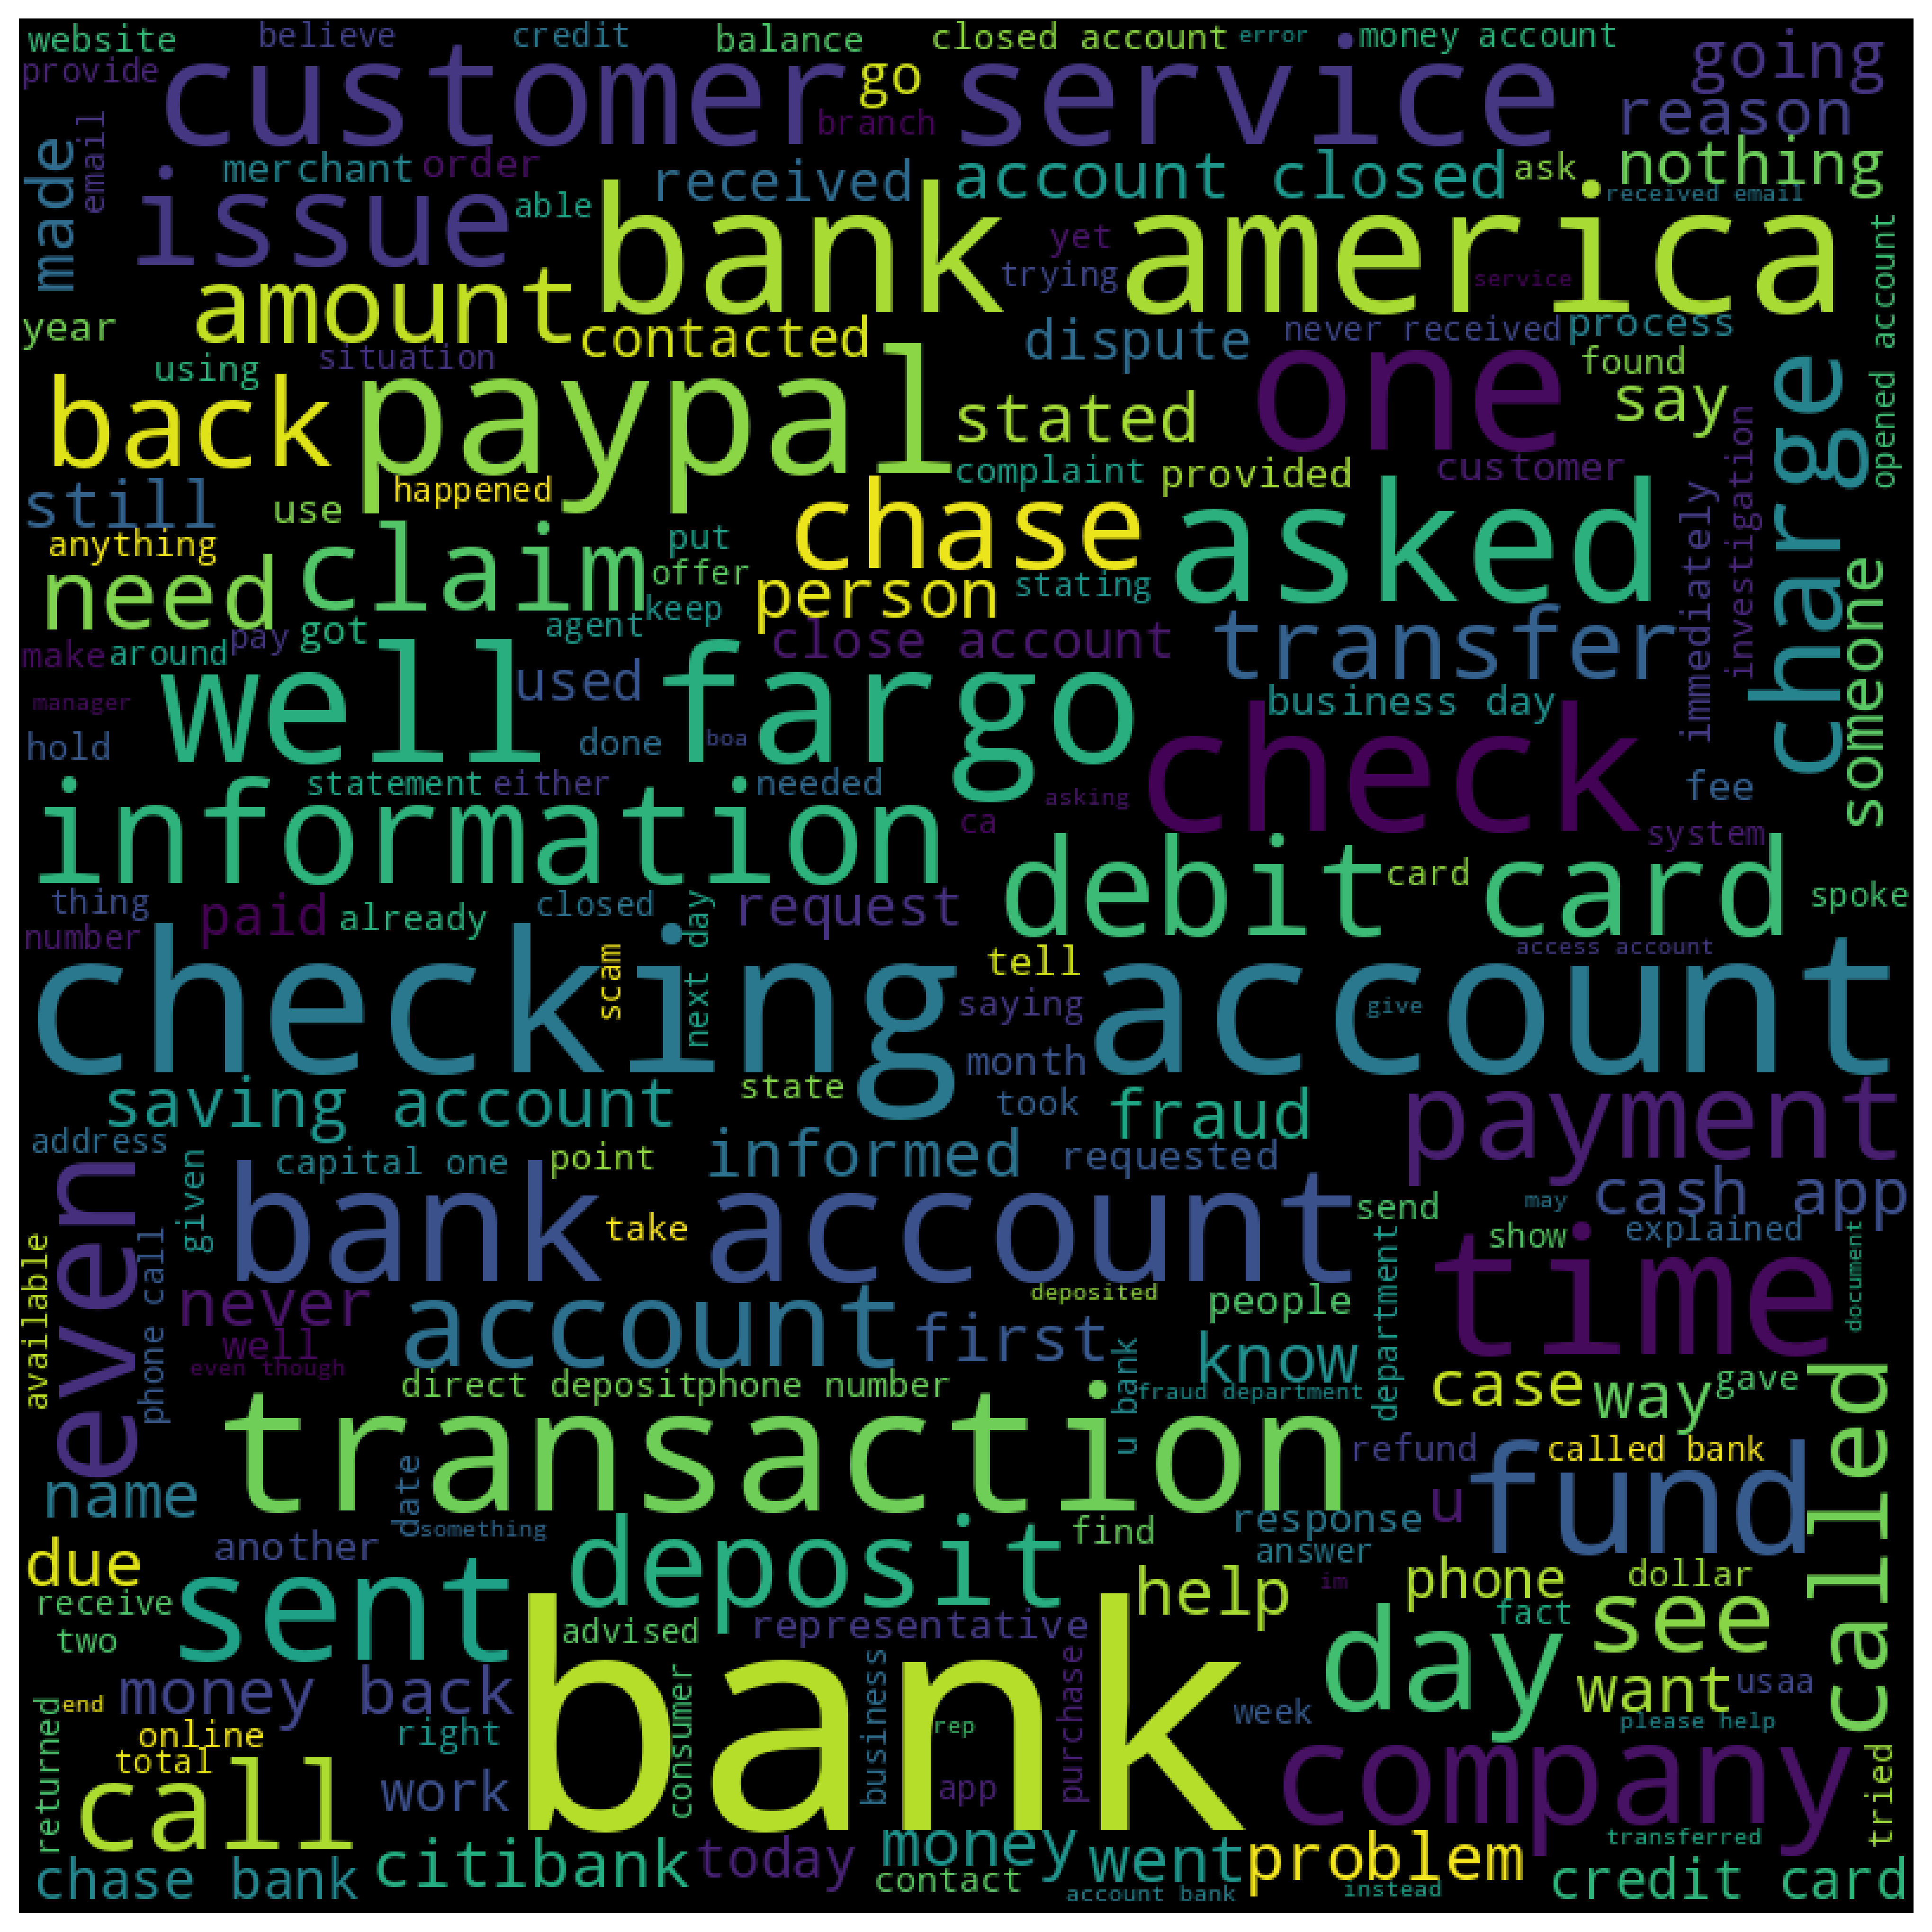

In [9]:
STOPWORDS = list(STOPWORDS)
STOPWORDS.extend(['told', 'said'])

# Creating the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)

# Displaying the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show()

The worldcloud here shows the most common words that are present in the complaints with the more frequent words being larger in size than the less frequent ones.

Next we will use KeyBERT to generate different topics from the customer complaints for better analyis of the data.

In [10]:
narratives = df_RB['narrative'].values

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [11]:
kw_model = KeyBERT()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [12]:
narratives_keywords, joined_keywords = list(), list()

for narrative in tqdm(narratives):
    keywords = kw_model.extract_keywords(narrative, keyphrase_ngram_range=(1, 3), stop_words='english', top_n=10)
    all_keywords = [x[0] for x in keywords]
    joins = " ".join([x[0] for x in keywords])
    narratives_keywords.append(all_keywords)
    joined_keywords.append(joins)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 10000/10000 [16:14<00:00, 10.26it/s]


In [15]:
dictionary = corpora.Dictionary(narratives_keywords)
corpus = [dictionary.doc2bow(text) for text in narratives_keywords]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [16]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [22]:
total_topics = 20

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



For the 20 topics generated through LDA, we can see the weightages of top 6 terms or words for that topic.

In [23]:
lda.show_topics(total_topics, 6)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[(0,
  '0.012*"contacted paypal" + 0.011*"account bank america" + 0.011*"account bank" + 0.005*"account account" + 0.005*"bank america" + 0.005*"bank pnc"'),
 (1,
  '0.006*"money pnc" + 0.005*"money transfer" + 0.005*"account locked" + 0.004*"said account" + 0.003*"received paypal" + 0.003*"chase claim"'),
 (2,
  '0.012*"chase account" + 0.006*"claim fargo" + 0.006*"account fargo" + 0.005*"fargo account" + 0.004*"account told" + 0.004*"trying link pnc"'),
 (3,
  '0.012*"checking account bank" + 0.006*"checking account" + 0.006*"chase checking account" + 0.006*"bank america fraud" + 0.005*"bank fraud" + 0.005*"citi bank"'),
 (4,
  '0.007*"transaction paypal" + 0.005*"cashapp account" + 0.004*"contacted chase" + 0.004*"money paypal" + 0.003*"chime bank" + 0.003*"card"'),
 (5,
  '0.005*"scam" + 0.005*"contacted cash app" + 0.004*"fraud" + 0.004*"contacted cash" + 0.003*"money checking account" + 0.003*"wallet stolen"'),
 (6,
  '0.015*"pnc account" + 0.011*"link pnc account" + 0.009*"link 

In [24]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
13     -10.878068   10.538728       1        1  27.178181
14     -60.884026  -75.591820       2        1   8.582325
4       -2.336119  -53.289074       3        1   4.760158
11     -61.385319  -12.914634       4        1   3.498786
17     -28.737743  126.296997       5        1   3.498784
19       1.066606 -123.552811       6        1   3.498784
18      45.140720   -7.947869       7        1   3.498784
16    -140.795975  -98.530548       8        1   3.498784
15      61.531681  -83.240562       9        1   3.498784
12     -72.563057 -140.396881      10        1   3.498784
0       15.984491   63.578186      11        1   3.498784
1     -160.851624   68.945145      12        1   3.498784
9       85.961830   51.922935      13        1   3.498784
8      -99.020836  109.936348      14        1   3.498784
7     -176.764130   -8.681684      15        1   3.498784
6     -117.189880  -37.420200      16        1   3.498784
5      108.829918  -22.946203      17        1   3.498784
3       47.588097  121.934814      18        1   3.498784
2     -106.467834   30.176889      19        1   3.498784
10     -50.613804   59.328842      20        1   3.498784, topic_info=                         Term       Freq      Total Category  logprob  loglift
2071           account hacked  34.000000  34.000000  Default  30.0000  30.0000
101                   account  16.000000  16.000000  Default  29.0000  29.0000
2972                 pnc bank  16.000000  16.000000  Default  28.0000  28.0000
1989               chase bank  10.000000  10.000000  Default  27.0000  27.0000
458              bank account  14.000000  14.000000  Default  26.0000  26.0000
...                       ...        ...        ...      ...      ...      ...
280    fargo checking account   1.001864   1.636011  Topic20  -5.8557   2.8624
4747      checking account td   0.672364   1.020433  Topic20  -6.2545   2.9356
4438         account received   0.559625   0.848691  Topic20  -6.4381   2.9363
14057       fraud transaction   0.494593   0.737646  Topic20  -6.5616   2.9530
3932                told bank   0.495537   1.277962  Topic20  -6.5597   2.4054

[866 rows x 6 columns], token_table=       Topic      Freq                        Term
term                                              
13776     11  1.275882         able access account
8074       4  1.288631             able cash check
12878      6  1.084756                   able link
4217       6  0.715556           able link account
10785     11  0.608149              access account
...      ...       ...                         ...
7030      14  1.008096                  wire fraud
3604      12  0.954436               wire transfer
16271      8  1.058611       wire transfer account
13171     16  1.482530           withdrawn account
6784       2  1.037908  withdrawn checking account

[667 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 15, 5, 12, 18, 20, 19, 17, 16, 13, 1, 2, 10, 9, 8, 7, 6, 4, 3, 11])

Next we will take a look at some of the customer complaints with maximum correspondence to the top topic words.

In [25]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(joined_keywords)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [26]:
lda_model = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [27]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print("Customer Complaints:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
            print()
        print('\n')
            
no_top_words = 15
no_top_documents = 5     
title_list = narratives
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  coinbase, venmo, wallet, bitcoin, coin, cryptocurrency, crypto, trading, currency, virtual, exchange, support, disabled, gift, vault
Customer Complaints:
invested crypto currency platform coinbase since access account locked reason nearly daily write support coinbase first tvey asked bankstatements detailed information gave since time dont respond need investment nobody able help

speaking behalf several friend engage cryptocurrency exchange poloniex operating u elsewhere parent company circle poloniex developed practice delisting coin certain amount time lapsed remove ability user access money ever list delist coin frequently creating confusion send email user marketing email frequent thus communication easy ignore due misconstrued spam exchange profit enormously process fact money belonged customer overnight like magic suddenly belongs exchange attempted follow support without even discussion said nothing could money lost strongly suggest nobody sign exchange sho

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



The dataframe below shows a matrix-like data that essentialy denotes how important a term is to the corresponding topic

In [30]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



contacted paypal  account bank america  account bank  account account  \
0           0.011608              0.010962      0.010807         0.005146   
1           0.000000              0.000000      0.000000         0.000000   
2           0.000000              0.000000      0.000000         0.000000   
3           0.000000              0.001749      0.004593         0.000000   
4           0.000000              0.000000      0.000000         0.000000   
5           0.000000              0.000000      0.000000         0.000000   
6           0.000000              0.000000      0.000000         0.000000   
7           0.000000              0.000000      0.000000         0.000000   
8           0.000000              0.000000      0.000000         0.000000   
9           0.000000              0.000000      0.000000         0.000000   
10          0.000000              0.000000      0.000000         0.000000   
11          0.000000              0.000000      0.000000         0.000000   
12          0.000000              0.000000      0.000000         0.000000   
13          0.000000              0.000000      0.000000         0.000000   
14          0.000000              0.000000      0.000000         0.000000   
15          0.000000              0.000000      0.000000         0.000000   
16          0.000000              0.000000      0.000000         0.000000   
17          0.000000              0.002702      0.001927         0.000000   
18          0.000000              0.000000      0.000000         0.000000   
19          0.000000              0.000000      0.000000         0.000000   

    bank america  bank pnc  account tried  access account  suntrust account  \
0       0.004896  0.004728       0.003948        0.003932          0.003414   
1       0.000000  0.000000       0.000000        0.000000          0.000000   
2       0.000000  0.000000       0.000000        0.000000          0.000000   
3       0.000000  0.000000       0.000000        0.000000          0.000000   
4       0.000000  0.000000       0.000000        0.000000          0.000000   
5       0.000000  0.000000       0.000000        0.000000          0.000000   
6       0.000000  0.000000       0.000000        0.000000          0.000000   
7       0.000000  0.000000       0.000000        0.000000          0.000000   
8       0.000000  0.000000       0.000000        0.000000          0.000000   
9       0.001985  0.000000       0.000000        0.000000          0.000000   
10      0.000000  0.000000       0.000000        0.000000          0.000000   
11      0.001227  0.000000       0.000000        0.000000          0.000000   
12      0.000000  0.000000       0.000000        0.000000          0.000000   
13      0.000000  0.000000       0.000000        0.000000          0.000000   
14      0.000000  0.000000       0.000000        0.000000          0.000000   
15      0.000000  0.000000       0.000000        0.000000          0.000000   
16      0.000000  0.000000       0.000000        0.000000          0.000000   
17      0.009754  0.000000       0.000000        0.000000          0.000000   
18      0.000000  0.000000       0.000000        0.000000          0.000000   
19      0.000000  0.000000       0.000000        0.000000          0.000000   

    bank account  ...  opened checking account      link  closing account  \
0       0.003412  ...                 0.000000  0.000000         0.000000   
1       0.000000  ...                 0.000000  0.000000         0.000000   
2       0.000000  ...                 0.000000  0.000000         0.000000   
3       0.000000  ...                 0.000000  0.000000         0.000000   
4       0.000000  ...                 0.000000  0.000000         0.000000   
5       0.000000  ...                 0.000000  0.000000         0.000000   
6       0.000000  ...                 0.000000  0.000000         0.000000   
7       0.000000  ...                 0.000000  0.000000         0.000000   
8       0.005816  ...            

We do the same process for the other products in the dataset.

## Debt Collection

In [36]:
df_DC = df[df['product'] == 'debt_collection']
df_DC.reset_index(inplace=True)
df_DC = df_RB[:10000]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [37]:
comment_words = ""
for i in df_DC.narrative: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
      
    comment_words += " ".join(separate)+" "

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



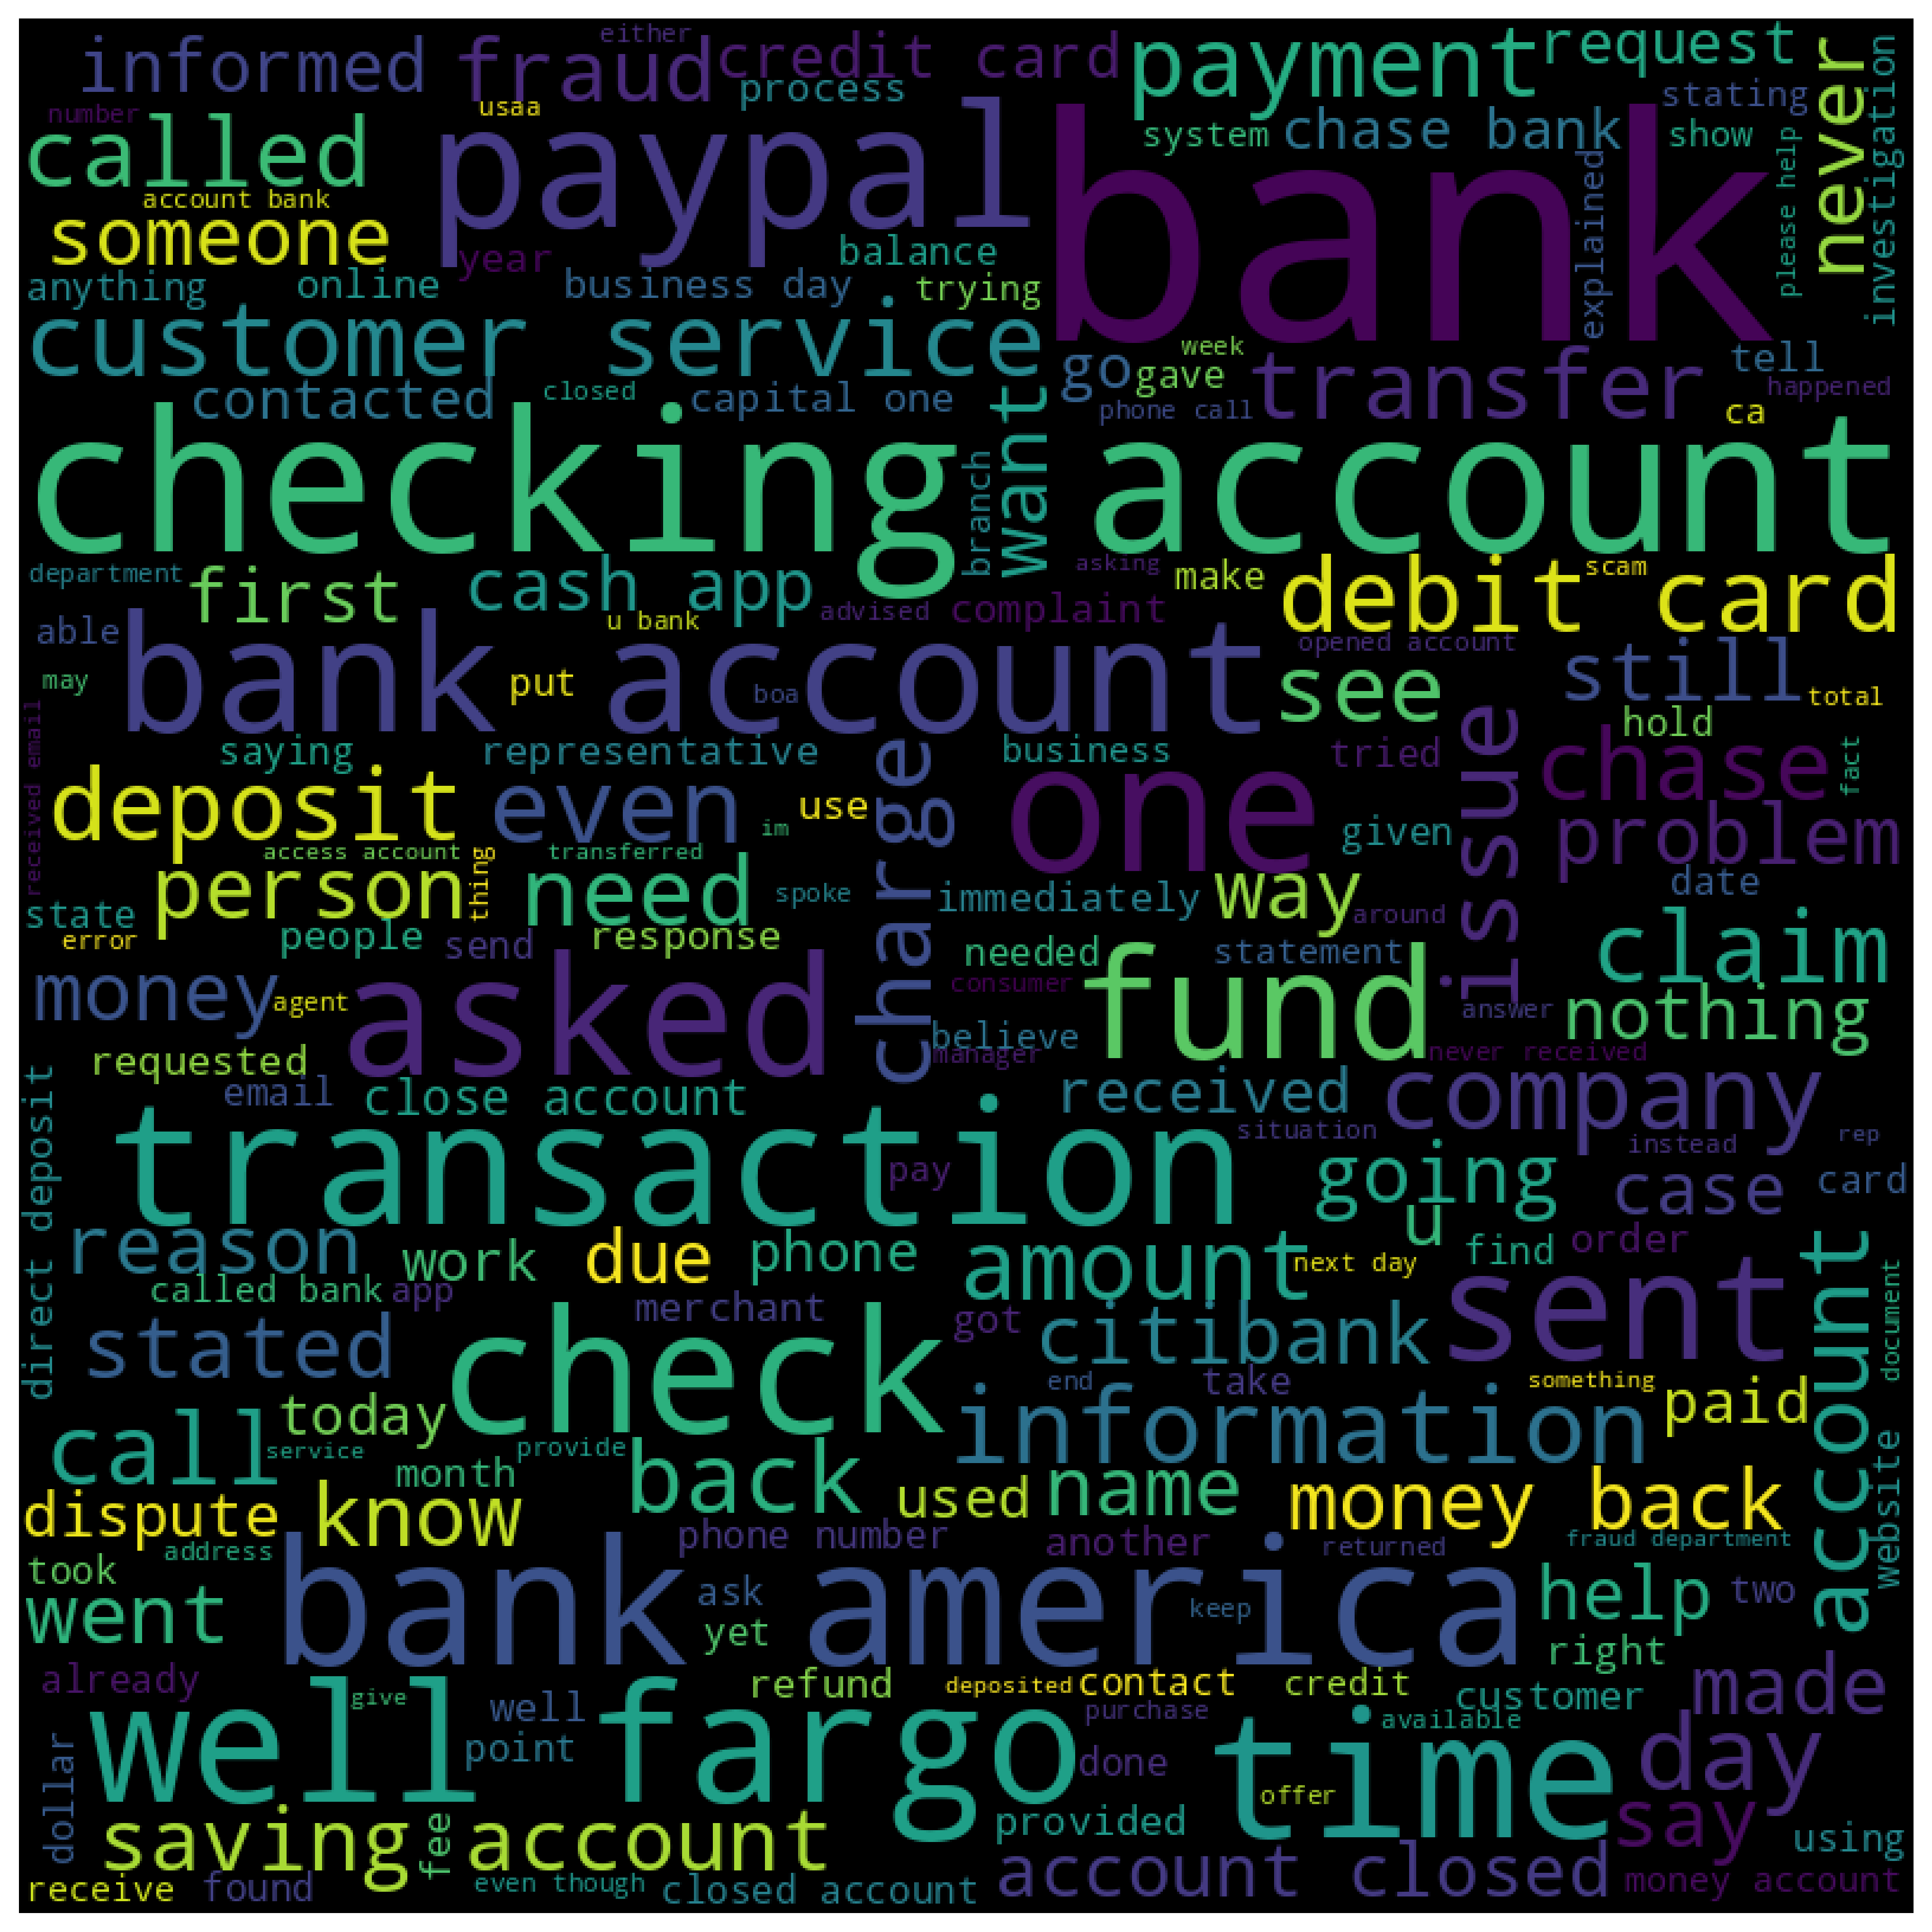

In [38]:
STOPWORDS = list(STOPWORDS)
STOPWORDS.extend(['told', 'said'])

# Creating the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)

# Displaying the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show()

In [40]:
narratives = df_DC['narrative'].values
narratives_keywords, joined_keywords = list(), list()

for narrative in tqdm(narratives):
    keywords = kw_model.extract_keywords(narrative, keyphrase_ngram_range=(1, 3), stop_words='english', top_n=10)
    all_keywords = [x[0] for x in keywords]
    joins = " ".join([x[0] for x in keywords])
    narratives_keywords.append(all_keywords)
    joined_keywords.append(joins)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 10000/10000 [16:15<00:00, 10.25it/s]


In [41]:
dictionary = corpora.Dictionary(narratives_keywords)
corpus = [dictionary.doc2bow(text) for text in narratives_keywords]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [42]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [43]:
total_topics = 20

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [44]:
lda.show_topics(total_topics, 6)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[(0,
  '0.010*"debit card" + 0.008*"transaction paypal" + 0.006*"bank america fraud" + 0.005*"chime bank" + 0.005*"card stolen" + 0.005*"scam"'),
 (1,
  '0.010*"opened checking account" + 0.007*"account frozen" + 0.006*"chase bank account" + 0.006*"chase bank" + 0.004*"bank fraud department" + 0.004*"account tried"'),
 (2,
  '0.026*"account" + 0.010*"link" + 0.008*"link account" + 0.006*"bank" + 0.005*"money pnc" + 0.004*"bank account"'),
 (3,
  '0.006*"bank statement" + 0.005*"account compromised" + 0.005*"bank check" + 0.004*"unauthorized transaction" + 0.003*"huntington bank" + 0.003*"fargo claim"'),
 (4,
  '0.005*"fargo account" + 0.005*"account fraud" + 0.003*"told bank" + 0.003*"account boa" + 0.003*"issue paypal" + 0.003*"deposit checking account"'),
 (5,
  '0.008*"paypal" + 0.007*"sent money" + 0.005*"hacked account" + 0.004*"check account" + 0.004*"bank close account" + 0.004*"business checking account"'),
 (6,
  '0.009*"closed account" + 0.008*"contacted bank" + 0.007*"deposi

In [45]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      -10.878068   10.538728       1        1  29.291640
1      -60.884026  -75.591820       2        1   8.202713
7       -2.336119  -53.289074       3        1   3.472536
8      -61.385319  -12.914634       4        1   3.472536
11     -28.737743  126.296997       5        1   3.472536
12       1.066606 -123.552811       6        1   3.472536
18      45.140720   -7.947869       7        1   3.472536
17    -140.795975  -98.530548       8        1   3.472536
16      61.531681  -83.240562       9        1   3.472536
15     -72.563057 -140.396881      10        1   3.472536
14      15.984491   63.578186      11        1   3.472536
13    -160.851624   68.945145      12        1   3.472536
10      85.961830   51.922935      13        1   3.472536
9      -99.020836  109.936348      14        1   3.472536
6     -176.764130   -8.681684      15        1   3.472536
5     -117.189880  -37.420200      16        1   3.472536
4      108.829918  -22.946203      17        1   3.472536
3       47.588097  121.934814      18        1   3.472536
2     -106.467834   30.176889      19        1   3.472536
19     -50.613804   59.328842      20        1   3.472536, topic_info=                      Term       Freq      Total Category  logprob  loglift
101                account  19.000000  19.000000  Default  30.0000  30.0000
5812            debit card  28.000000  28.000000  Default  29.0000  29.0000
2972              pnc bank  11.000000  11.000000  Default  28.0000  28.0000
2150           pnc account   9.000000   9.000000  Default  27.0000  27.0000
458           bank account  14.000000  14.000000  Default  26.0000  26.0000
...                    ...        ...        ...      ...      ...      ...
106       checking account   1.769131  18.490698  Topic20  -5.2796   1.0135
7020  new checking account   0.729281   2.328011  Topic20  -6.1658   2.1996
96              pnc change   0.659852   1.863371  Topic20  -6.2658   2.3222
458           bank account   0.861872  14.202787  Topic20  -5.9987   0.5582
633   pnc checking account   0.548048   2.289895  Topic20  -6.4514   1.9304

[849 rows x 6 columns], token_table=       Topic      Freq                        Term
term                                              
2340      10  1.650969                        able
13776      1  1.000988         able access account
8074       3  1.394646             able cash check
12878      6  1.049463                   able link
4217       6  0.662126           able link account
...      ...       ...                         ...
3604       5  0.936663               wire transfer
16271      3  1.094529       wire transfer account
2209       2  0.926278               withdraw fund
13171      9  1.408466           withdrawn account
6784       6  1.294228  withdrawn checking account

[626 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 8, 9, 12, 13, 19, 18, 17, 16, 15, 14, 11, 10, 7, 6, 5, 4, 3, 20])

In [46]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(joined_keywords)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [47]:
lda_model = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [48]:
no_top_words = 15
no_top_documents = 5     
title_list = narratives
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  coinbase, venmo, wallet, bitcoin, coin, cryptocurrency, crypto, trading, currency, virtual, exchange, support, disabled, gift, vault
Customer Complaints:
invested crypto currency platform coinbase since access account locked reason nearly daily write support coinbase first tvey asked bankstatements detailed information gave since time dont respond need investment nobody able help

speaking behalf several friend engage cryptocurrency exchange poloniex operating u elsewhere parent company circle poloniex developed practice delisting coin certain amount time lapsed remove ability user access money ever list delist coin frequently creating confusion send email user marketing email frequent thus communication easy ignore due misconstrued spam exchange profit enormously process fact money belonged customer overnight like magic suddenly belongs exchange attempted follow support without even discussion said nothing could money lost strongly suggest nobody sign exchange sho

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [49]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



debit card  transaction paypal  bank america fraud  chime bank  \
0     0.009782            0.007696            0.006381    0.005443   
1     0.000000            0.000000            0.000000    0.000000   
2     0.000000            0.000000            0.000000    0.000000   
3     0.000000            0.000000            0.000000    0.000000   
4     0.000000            0.000000            0.000000    0.000000   
5     0.000000            0.000000            0.000000    0.000000   
6     0.000000            0.000000            0.000000    0.000000   
7     0.000000            0.000000            0.000000    0.000000   
8     0.000000            0.000000            0.000000    0.000000   
9     0.000000            0.000000            0.000000    0.000000   
10    0.000000            0.000000            0.000000    0.000000   
11    0.000000            0.000000            0.000000    0.000000   
12    0.000000            0.000000            0.000000    0.000000   
13    0.000000            0.000000            0.000000    0.000000   
14    0.000000            0.000000            0.000000    0.000000   
15    0.000000            0.000000            0.000000    0.000000   
16    0.000000            0.000000            0.000000    0.005977   
17    0.000000            0.000000            0.000000    0.000000   
18    0.000000            0.000000            0.000000    0.000000   
19    0.000000            0.000000            0.000000    0.000000   

    card stolen      scam  closing account  debit card stolen  hold check  \
0       0.00518  0.004631         0.004456            0.00391    0.003385   
1       0.00000  0.000000         0.000000            0.00000    0.000000   
2       0.00000  0.000000         0.000000            0.00000    0.000000   
3       0.00000  0.000000         0.000000            0.00000    0.000000   
4       0.00000  0.000000         0.000000            0.00000    0.000000   
5       0.00000  0.000000         0.000000            0.00000    0.000000   
6       0.00000  0.000000         0.000000            0.00000    0.000000   
7       0.00000  0.000000         0.000000            0.00000    0.000000   
8       0.00000  0.000000         0.000000            0.00000    0.000000   
9       0.00000  0.000000         0.000000            0.00000    0.000000   
10      0.00000  0.000000         0.000000            0.00000    0.000000   
11      0.00000  0.000000         0.001706            0.00000    0.000000   
12      0.00000  0.000000         0.000000            0.00000    0.000000   
13      0.00000  0.000000         0.000000            0.00000    0.000000   
14      0.00000  0.000000         0.000000            0.00000    0.000000   
15      0.00000  0.000000         0.000000            0.00000    0.000000   
16      0.00000  0.000000         0.000000            0.00000    0.000000   
17      0.00000  0.000000         0.000000            0.00000    0.000000   
18      0.00000  0.000000         0.000000            0.00000    0.000000   
19      0.00000  0.000000         0.000000            0.00000    0.000000   

    contacted chase bank  ...  account balance  contacted chime  loan sba  \
0               0.003043  ...         0.000000         0.000000  0.000000   
1               0.000000  ...         0.000000         0.000000  0.000000   
2               0.000000  ...         0.000000         0.000000  0.000000   
3               0.000000  ...         0.000000         0.000000  0.000000   
4               0.000000  ...         0.000000         0.000000  0.000000   
5               0.000000  ...         0.000000         0.000000  0.000000   
6               0.000000  ...         0.000000         0.000000  0.000000   
7               0.000000  ...         0.000000         0.000000  0.000000   
8               0.000000  ...         0.000000         0.000000  0.000000   
9               0.000000  ...         0.000000         0.000000  0.000000   
10              0.000000  ...         0.000000         0.000000  0.0

## Transaction Processing

In [50]:
df_TP = df[df['product'] == 'Transaction Processing']
df_TP.reset_index(inplace=True)
df_TP = df_TP[:10000]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [52]:
comment_words = ""
for i in df_TP.narrative: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
      
    comment_words += " ".join(separate)+" "

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



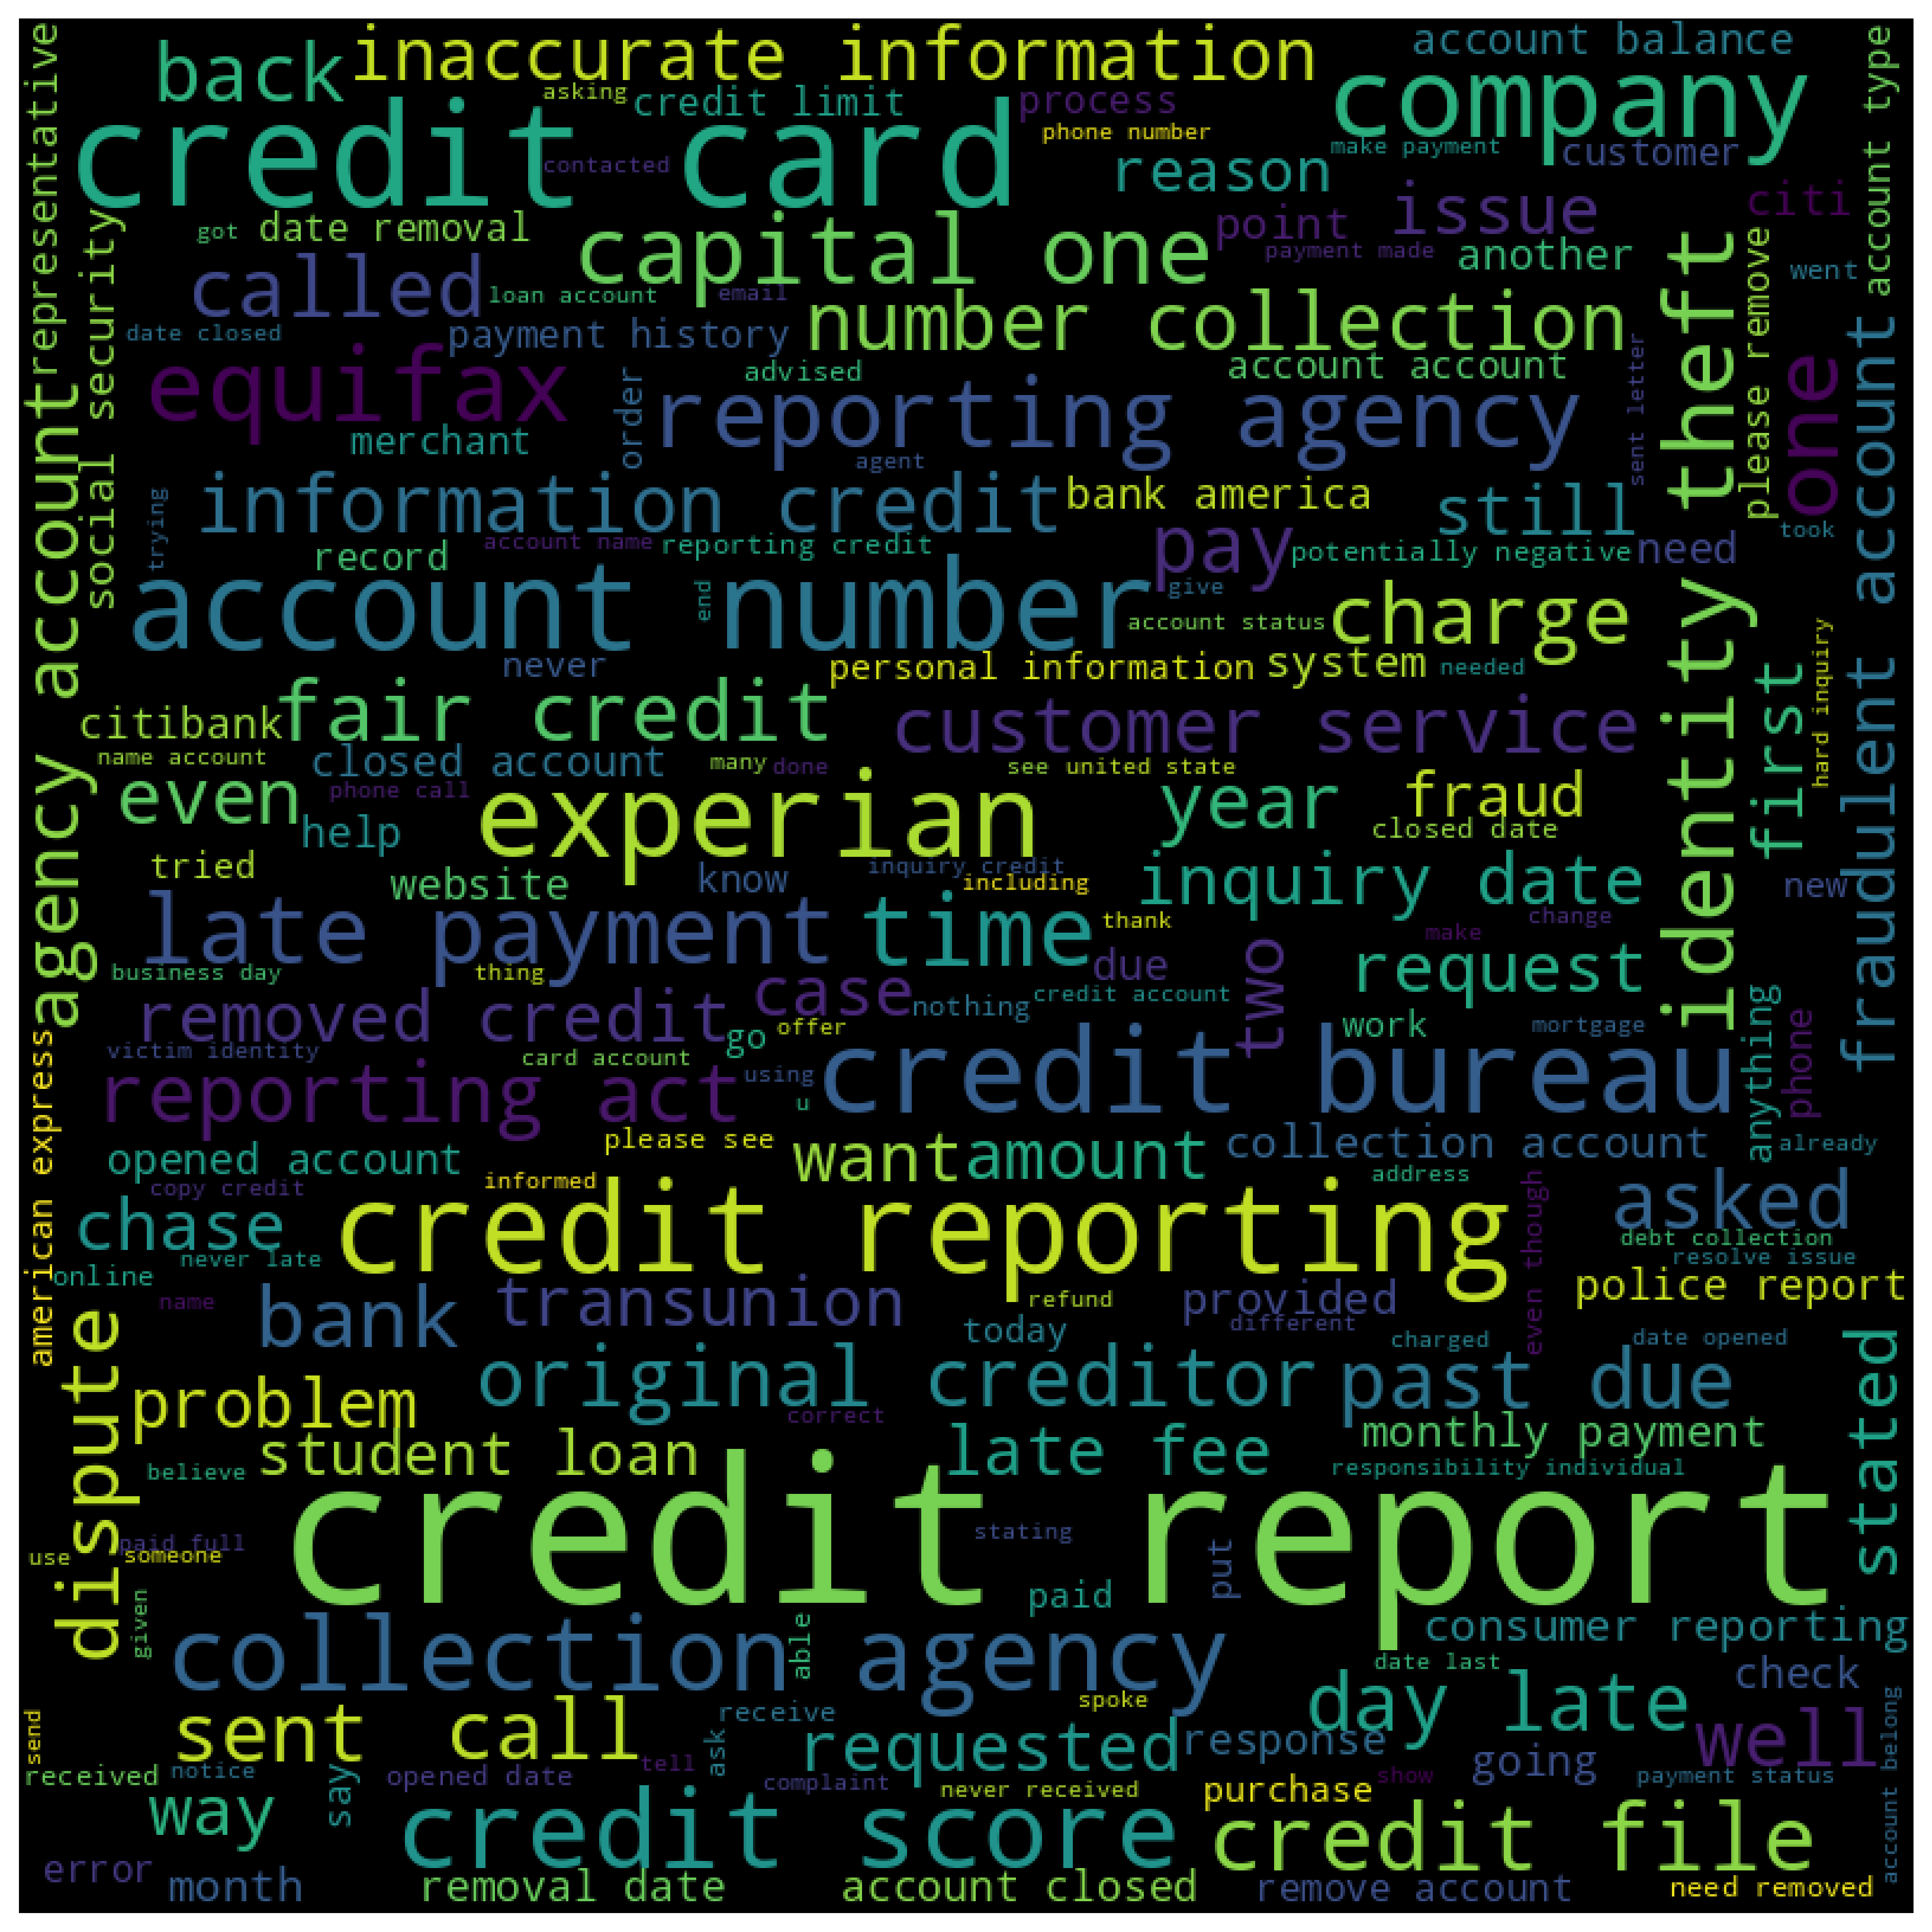

In [53]:
STOPWORDS = list(STOPWORDS)
STOPWORDS.extend(['told', 'said'])

# Creating the Word Cloud
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)

# Displaying the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show()

In [54]:
narratives = df_TP['narrative'].values
narratives_keywords, joined_keywords = list(), list()

for narrative in tqdm(narratives):
    keywords = kw_model.extract_keywords(narrative, keyphrase_ngram_range=(1, 3), stop_words='english', top_n=10)
    all_keywords = [x[0] for x in keywords]
    joins = " ".join([x[0] for x in keywords])
    narratives_keywords.append(all_keywords)
    joined_keywords.append(joins)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 10000/10000 [14:47<00:00, 11.27it/s]


In [55]:
dictionary = corpora.Dictionary(narratives_keywords)
corpus = [dictionary.doc2bow(text) for text in narratives_keywords]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [56]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [57]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [58]:
total_topics = 20

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [59]:
lda.show_topics(total_topics, 6)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[(0,
  '0.027*"account credit report" + 0.015*"reporting credit report" + 0.014*"report credit" + 0.012*"credit report" + 0.010*"reporting credit" + 0.009*"reporting account"'),
 (1,
  '0.017*"cfpb" + 0.006*"credit bureau reported" + 0.005*"creditor account" + 0.004*"account fraud" + 0.004*"pull credit report" + 0.004*"creditor status"'),
 (2,
  '0.008*"dispute credit" + 0.008*"dispute credit bureau" + 0.008*"credit file" + 0.007*"item credit" + 0.006*"item credit report" + 0.006*"account credit file"'),
 (3,
  '0.015*"equifax refuse" + 0.009*"mistake credit report" + 0.009*"transunion credit report" + 0.009*"transunion credit" + 0.008*"fraudulent information" + 0.007*"disputed account"'),
 (4,
  '0.022*"bankruptcy" + 0.012*"report credit bureau" + 0.010*"closed account" + 0.010*"report information credit" + 0.008*"equifax reporting account" + 0.007*"account closed"'),
 (5,
  '0.041*"credit report" + 0.040*"credit reporting act" + 0.039*"credit reporting" + 0.022*"removed credit report

In [60]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      -10.878068   10.538728       1        1  25.233629
19     -60.884026  -75.591820       2        1   6.812992
15      -2.336119  -53.289074       3        1   5.688478
6      -61.385319  -12.914634       4        1   3.669901
13     -28.737743  126.296997       5        1   3.662188
3        1.066606 -123.552811       6        1   3.662188
7       45.140720   -7.947869       7        1   3.662187
9     -140.795975  -98.530548       8        1   3.662187
18      61.531681  -83.240562       9        1   3.662187
17     -72.563057 -140.396881      10        1   3.662187
16      15.984491   63.578186      11        1   3.662187
14    -160.851624   68.945145      12        1   3.662187
0       85.961830   51.922935      13        1   3.662187
12     -99.020836  109.936348      14        1   3.662187
11    -176.764130   -8.681684      15        1   3.662187
8     -117.189880  -37.420200      16        1   3.662187
5      108.829918  -22.946203      17        1   3.662187
4       47.588097  121.934814      18        1   3.662187
2     -106.467834   30.176889      19        1   3.662187
10     -50.613804   59.328842      20        1   3.662187, topic_info=                           Term       Freq      Total Category  logprob  \
4538    credit report contacted  21.000000  21.000000  Default  30.0000   
1124      removed credit report  39.000000  39.000000  Default  29.0000   
103               credit report  70.000000  70.000000  Default  28.0000   
824        credit reporting act  33.000000  33.000000  Default  27.0000   
457   information credit report  30.000000  30.000000  Default  26.0000   
...                         ...        ...        ...      ...      ...   
300                credit score   1.364526   8.124532  Topic20  -5.5924   
1124      removed credit report   1.736804  39.295786  Topic20  -5.3512   
1089      account credit report   1.558924  26.389888  Topic20  -5.4592   
3986       report credit bureau   1.175195   6.420738  Topic20  -5.7418   
457   information credit report   1.237173  30.901804  Topic20  -5.6904   

      loglift  
4538  30.0000  
1124  29.0000  
103   28.0000  
824   27.0000  
457   26.0000  
...       ...  
300    1.5230  
1124   0.1880  
1089   0.4781  
3986   1.6090  
457    0.0891  

[884 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
4474     20  0.815570  access credit report
7802      3  0.703433       accordance fcra
92        1  0.184393               account
92        3  0.092196               account
92        7  0.092196               account
...     ...       ...                   ...
865      15  0.166516        violation fcra
866      15  0.609110   violation fcra rule
989       6  1.552002         violation ftc
3152      3  1.082432  violation right fcra
9616     13  1.307765         wrong account

[784 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 20, 16, 7, 14, 4, 8, 10, 19, 18, 17, 15, 1, 13, 12, 9, 6, 5, 3, 11])

In [61]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(joined_keywords)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [62]:
lda_model = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [63]:
no_top_words = 15
no_top_documents = 5     
title_list = narratives
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  card, partial, credit, closed, account, balance, limit, opened, capital, lowered, close, charged, fargo, bank, fee
Customer Complaints:
chase unilaterally closed credit card account year supposedly assert sent single letter use lose message never received good standing never missed late payment nearly two decade overall credit score action risked damaging credit score reducing available credit single letter completely unaccepable spoke customer service representative approximately day unilateral action discovered quite accident told nothing could completely unacceptable looking cfpb website kind behavior seems common occurence chase gravely disappointing believe need address kind abuse customer would minimum institute process fewer three letter cardholder closing account cost associated confident would swiftly recouped customer using formerly dormant card maintain card validity generating fresh profit chase certainly recommending chase anyone

bank america refuse c

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [64]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



account credit report  reporting credit report  report credit  \
0                0.026681                 0.015128       0.014024   
1                0.000000                 0.000000       0.000000   
2                0.000000                 0.000000       0.000000   
3                0.000000                 0.000000       0.000000   
4                0.000000                 0.000000       0.006096   
5                0.016101                 0.000000       0.000000   
6                0.000000                 0.000000       0.000000   
7                0.000000                 0.000000       0.000000   
8                0.000000                 0.000000       0.000000   
9                0.000000                 0.000000       0.000000   
10               0.004257                 0.000000       0.000000   
11               0.000000                 0.000000       0.000000   
12               0.000000                 0.009564       0.000000   
13               0.000000                 0.000000       0.000000   
14               0.000000                 0.000000       0.000000   
15               0.000000                 0.000000       0.000000   
16               0.003317                 0.000000       0.000000   
17               0.000000                 0.000000       0.000000   
18               0.005033                 0.000000       0.000000   
19               0.006738                 0.000000       0.000000   

    credit report  reporting credit  reporting account  inquiry date removal  \
0        0.011733          0.009539           0.009088              0.008282   
1        0.003024          0.000000           0.000000              0.000000   
2        0.000000          0.000000           0.000000              0.000000   
3        0.000000          0.000000           0.000000              0.000000   
4        0.003990          0.000000           0.000000              0.000000   
5        0.041138          0.000000           0.000000              0.000000   
6        0.003035          0.000000           0.000000              0.000000   
7        0.000000          0.000000           0.000000              0.000000   
8        0.005737          0.000000           0.000000              0.000000   
9        0.004120          0.000000           0.000000              0.000000   
10       0.028278          0.000000           0.000000              0.000000   
11       0.000000          0.000000           0.000000              0.000000   
12       0.007595          0.014726           0.000000              0.000000   
13       0.000000          0.000000           0.000000              0.000000   
14       0.004959          0.003637           0.000000              0.000000   
15       0.000000          0.000000           0.000000              0.000000   
16       0.010368          0.000000           0.000000              0.000000   
17       0.000000          0.000000           0.000000              0.000000   
18       0.027589          0.000000           0.000000              0.000000   
19       0.009183          0.000000           0.000000              0.000000   

    account credit  violation fair credit  remove account credit  ...  \
0         0.006604                0.00659               0.006295  ...   
1         0.000000                0.00000               0.000000  ...   
2         0.002270                0.00000               0.002974  ...   
3         0.000000                0.00000               0.000000  ...   
4         0.000000                0.00000               0.000000  ...   
5         0.013972                0.00000               0.000000  ...   
6         0.000000                0.00000               0.000000  ...   
7         0.000000                0.00000               0.000000  ...   
8         0.000000                0.00000               0.000000  ...   
9         0.000000                0.00000               0.000000  ...   
10        0.000000                0.00000               0.000000  ... 